In [38]:
import sys 
sys.path.insert(0,'../')
import pymce2 as mce

import numpy as np
import glob
import scipy.io as sio
import h5py
from time import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA,TruncatedSVD,NMF,FastICA
from sklearn.metrics import roc_auc_score
from sklearn import neighbors 
from sklearn.ensemble import IsolationForest

import pandas as pd
import matplotlib.pylab as plt
from matplotlib import gridspec
%matplotlib inline

In [2]:
agg = AgglomerativeClustering()

In [3]:
# fils = glob.glob('../../data/benchmark/*.mat')
import os
fils = sorted(glob.glob('../../data/benchmark/*.mat'), key=os.path.getsize)
fils = ['../../data/benchmark/letter.mat']
def job(X,y,n_t):
    return quick_outlier_analysis(X,y,3)

n_try = 3
# i=0
for i in range(len(fils)):
# for i in range(1):
    print fils[i].split('/')[-1][:-4]
    try:
        data = sio.loadmat(fils[i])
        X = data['X'].astype(float)
        y = data['y']
    except:
        data = h5py.File(fils[i])
        X = np.array(data['X']).T
        y = np.array(data['y']).T
        
    print X.shape

x_in = X[(y==0).reshape(-1)]
x_ot = X[(y==1).reshape(-1)]
inds = np.argsort(np.mean(x_in,axis=0))
X = X[:,inds]
x_in = X[(y==0).reshape(-1)]
x_ot = X[(y==1).reshape(-1)]

letter
(1600, 32)


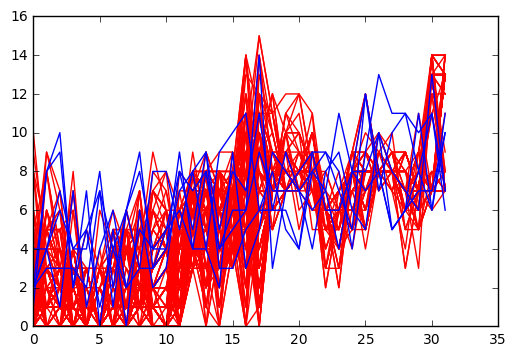

In [4]:
for i in range(142):
    plt.plot(x_in[i],'r')
    
for i in range(6):
    plt.plot(x_ot[i],'b')

In [5]:
z_dim = 2
dim_rs ={'AE':'AE','VAE':'VAE','none':'none','PCA':PCA(n_components=z_dim),'NMF':NMF(n_components=2), 
         'FastICA':FastICA(n_components=2, max_iter=1000)}
# dim_rs ={'none':'none'}

metrics = ['correlation','mahalanobis','L2']
# metrics = ['mahalanobis']
for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition
    splitter = mce.Splitter(X, reducer = value, clustering = agg.fit_predict, z_dim=z_dim)

    # Splitting
    splitter.split(1,verbose=0,training_epochs=20)
    
    # outlier extraction for all of requeste metrics
    outliers_r = mce.outliers(X,splitter,metrics)
    outliers_l = mce.outliers_latent(splitter,metrics) 
    
    for metr in metrics:
        print '{:<12}: real:{:2.2f}, latent:{:2.2f}'.format(metr,roc_auc_score(y==1, outliers_r[metr]),
                                              roc_auc_score(y==1, outliers_l[metr]))


---------------  none  ----------------
correlation : real:0.73, latent:0.73
mahalanobis : real:0.88, latent:0.88
L2          : real:0.67, latent:0.67
---------------  AE  ----------------
correlation : real:0.51, latent:0.50
mahalanobis : real:0.80, latent:0.50
L2          : real:0.49, latent:0.50
---------------  VAE  ----------------
correlation : real:0.59, latent:0.47
mahalanobis : real:0.84, latent:0.53
L2          : real:0.42, latent:0.50
---------------  NMF  ----------------
correlation : real:0.72, latent:0.51
mahalanobis : real:0.88, latent:0.66
L2          : real:0.65, latent:0.64
---------------  FastICA  ----------------
correlation : real:0.66, latent:0.49
mahalanobis : real:0.87, latent:0.44
L2          : real:0.59, latent:0.46
---------------  PCA  ----------------
correlation : real:0.72, latent:0.46
mahalanobis : real:0.87, latent:0.58
L2          : real:0.65, latent:0.54


In [6]:
X_train = X
X_test = X
y_test = y

In [33]:
def full_test(X_train,X_test,y_test,j,levs,o_list,z_dim=2):
    dim_rs ={'AE':'AE','VAE':'VAE','none':'none','PCA':PCA(n_components=z_dim),'NMF':NMF(n_components=2), 
             'FastICA':FastICA(n_components=2, max_iter=1000)}

    dr_name = ['AE','VAE','none','PCA','NMF','FastICA']
    dr_f = ['AE','VAE','none',PCA(n_components=z_dim),
            NMF(n_components=z_dim),FastICA(n_components=z_dim, max_iter=1000)]

    dim_rs ={dr_name[j]:dr_f[j]}
    # dim_rs ={'none':'none'}
    metrics = mce.metrics

    # metrics = ['mahalanobis']

    columns = ['DRT','level','Metric','detspace']+['AUC','MCC','BRU']
    n_row = 2*levs*len(dim_rs)*(len(metrics)+1)
    index = np.arange(n_row) # array of numbers for the number of samples
    df = pd.DataFrame(columns=columns, index = index)

    exec 'T_o ='+(' | '.join(['(y_test=='+str(i)+')' for i in o_list]))

    i = -1
    for dim_r, value in dim_rs.iteritems():

        print '---------------  '+dim_r+'  ----------------'
        t0 = time()
        for lev in range(levs):
            # Splitter definition
            splitter = mce.Splitter(X_train, reducer = value, clustering = agg.fit_predict, z_dim=z_dim)

            # Splitting
            splitter.split(1,verbose=0,training_epochs=20)

            # outlier extraction for all of requeste metrics
            outliers_r = mce.outliers(X_test,splitter,metrics)
            outliers_l = mce.outliers_latent(splitter,metrics) 

            for metr in metrics:

                i += 1
                df['DRT'][i] = dim_r
                df['level'][i] = lev+1
                df['Metric'][i] = metr
                df['detspace'][i] = 'real'
                df['AUC'][i] = roc_auc_score(T_o, outliers_r[metr])
                df['MCC'][i] = mce.MCC(T_o, outliers_r[metr])
                df['BRU'][i] = mce.bru_score(T_o, outliers_r[metr])

                i += 1
                df['DRT'][i] = dim_r
                df['level'][i] = lev+1
                df['Metric'][i] = metr
                df['detspace'][i] = 'latent'                  
                df['AUC'][i] = roc_auc_score(T_o, outliers_l[metr])
                df['MCC'][i] = mce.MCC(T_o, outliers_l[metr])
                df['BRU'][i] = mce.bru_score(T_o, outliers_l[metr])

            i += 1
            df['DRT'][i] = dim_r
            df['level'][i] = lev+1
            df['Metric'][i] = 'ens'
            df['detspace'][i] = 'real'  
            ens_out = mce.norm_ensemble(outliers_r,0.1)
            df['AUC'][i] = roc_auc_score(T_o, ens_out)
            df['MCC'][i] = mce.MCC(T_o, ens_out)
            df['BRU'][i] = mce.bru_score(T_o, ens_out)

            i += 1
            df['DRT'][i] = dim_r
            df['level'][i] = lev+1
            df['Metric'][i] = 'ens'
            df['detspace'][i] = 'latent' 
            ens_out = mce.norm_ensemble(outliers_l,0.1)
            df['AUC'][i] = roc_auc_score(T_o, ens_out)
            df['MCC'][i] = mce.MCC(T_o, ens_out)
            df['BRU'][i] = mce.bru_score(T_o, ens_out)        
        t1 = time()
        
    return df,t1-t0

In [35]:
j=0

levs = 3
o_list = [1]
z_dim = 2

df,dt = full_test(X_train,X_test,y_test,j,levs,o_list,z_dim=2)

---------------  AE  ----------------


In [37]:
dt
# df.sort_values(by=['BRU'], ascending=[False])

25.78820490837097

In [49]:
def sk_check(X_train,X_test,y_test,o_list):
    f_f = [neighbors.LocalOutlierFactor(n_neighbors=5),\
    neighbors.LocalOutlierFactor(n_neighbors=10),\
    neighbors.LocalOutlierFactor(n_neighbors=35),\
    IsolationForest(max_samples='auto')]
    f_name = ['LOF5','LOF10','LOF35','i-forest']

    columns = ['method']+['AUC','MCC','BRU']
    n_row = 2
    index = np.arange(n_row) # array of numbers for the number of samples
    df = pd.DataFrame(columns=columns, index = index)

    exec 'T_o ='+(' | '.join(['(y_test=='+str(i)+')' for i in o_list]))

    auc_max = -1
    for i in range(3):
        lof = f_f[i]
        lof.fit(X_test)
        outliers = -lof.negative_outlier_factor_

        auc_test = roc_auc_score(T_o, outliers)
        if auc_test>auc_max:
            auc_max = auc_test
            df['method'][0] = f_name[i]
            df['MCC'][0] = mce.MCC(T_o, outliers)
            df['AUC'][0] = auc_max
            df['BRU'][0] = mce.bru_score(T_o, outliers)

    df['method'][1] = f_name[3]
    isof = f_f[3]
    isof.fit(X_train)
    scores_pred = isof.decision_function(X_test)
    outliers = scores_pred.max()-scores_pred
    df['MCC'][1] = mce.MCC(T_o, outliers)
    df['AUC'][1] = roc_auc_score(T_o, outliers)
    df['BRU'][1] = mce.bru_score(T_o, outliers)

    return df


In [50]:
sk_check(X_train,X_test,y_test,o_list)

,method,AUC,MCC,BRU
0,LOF10,0.912907,0.498667,0.360396
1,i-forest,0.62804,0.0613333,0.124554
